In [2]:
# Prepare the standard modules
from pylab import *
import scipy.io as sio
%matplotlib inline
rcParams['figure.figsize']=(12,3)  # Change the default figure size

In [1]:
pip install nitime

     |████████████████████████████████| 6.2MB 10.3MB/s 
  Created wheel for nitime: filename=nitime-0.9-cp37-cp37m-linux_x86_64.whl size=4032127 sha256=ca57bfe5e297f96ff3271d7e117f49b1ffffe83b274e5fa64f5b8f5116e7fa81
  Stored in directory: /root/.cache/pip/wheels/9d/d6/a7/ecbf971b5b91880cbba499bb10d949e84266f24396a916ddb5
Successfully built nitime


In [3]:
# Import the tools for the notebook
import nitime.algorithms.spectral as spectrum
from scipy.stats import chi2

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


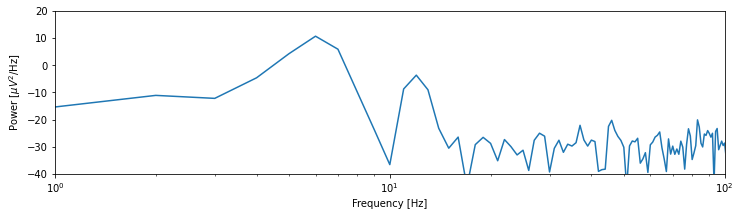

In [5]:
data = sio.loadmat('/content/gdrive/MyDrive/Colab Notebooks/Data/Python EEG/Case-Studies-Python-student/matfiles/04_ECoG-1.mat')    # Load the ECoG data.
x    = data['ECoG'].reshape(-1)          # Extract the ECoG variable,
t    = data['t'][0]                      # ... and the t variable

dt = t[1] - t[0]                         # Define the sampling interval.
N = x.shape[0]                           # Define the total number of data points.
T = N * dt                               # Define the total duration of the data.

x  = hanning(N) * x                      # Apply the Hanning taper to the data.
xf = fft(x - x.mean())                   # Compute Fourier transform of x.
Sxx = 2 * dt ** 2 / T * (xf * conj(xf))  # Compute the spectrum,
Sxx = real(Sxx[:int(len(x) / 2)])        # ... and ignore negative frequencies.

df = 1 / T.max()                         # Determine the frequency resolution.
fNQ = 1 / dt / 2                         # Determine the Nyquist frequency.
faxis = arange(0,fNQ,df)                 # Construct a frequency axis.

semilogx(faxis[1:],10*log10(Sxx[1:]))    # Plot spectrum vs frequency,
xlim([faxis[1], 100])                    # Select frequency range,
ylim([-40, 20])                          # ... and the power range.
xlabel('Frequency [Hz]')                 # Label the axes
ylabel('Power [$\mu V^2$/Hz]')
show()

## Data analysis

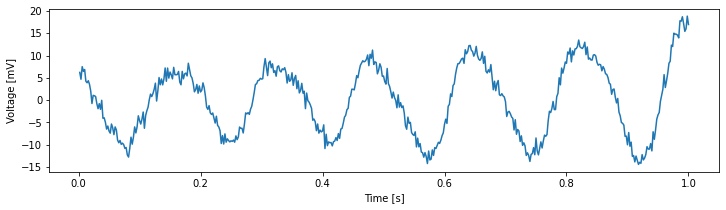

In [7]:
data = sio.loadmat('/content/gdrive/MyDrive/Colab Notebooks/Data/Python EEG/Case-Studies-Python-student/matfiles/04_ECoG-1.mat')  # Load the ECoG data
ecog = data['ECoG'].reshape(-1)   # Extract the ECoG variable
t = data['t'][0]                  # ... and the t variable

plot(t, ecog)                     # Plot the data versus time
xlabel('Time [s]')                # Label the time axis
ylabel('Voltage [mV]')            # ... and the voltage axis
show()

# We see dominant 6Hz rhythm 

## Spectral Analysis: The Rectangular Taper and Zero Padding

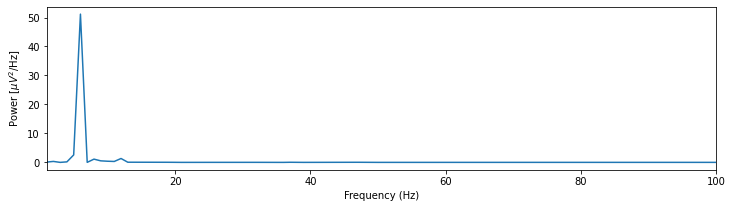

In [8]:
x = ecog          # Relabel the data variable
dt = t[2] - t[1]  # Define the sampling interval
T = t[-1]         # ... and duration of data

xf = rfft(x - x.mean())                        # Compute the Fourier transform of x,
Sxx = real(2 * dt ** 2 / T * (xf * conj(xf)))  # ... and the spectrum.

df = 1 / T                                     # Define the frequency resolution.
fNQ = 1 / dt / 2                               # Define the Nyquist frequency.
faxis = arange(len(Sxx)) * df                  # Construct the frequency axis.
plot(faxis, Sxx)                               # Plot spectrum vs. frequency,
xlim([1, 100])                                 # ... in select frequency range,
xlabel('Frequency (Hz)')                       # ... with axes labeled.
ylabel('Power [$\mu V^2$/Hz]')
show()

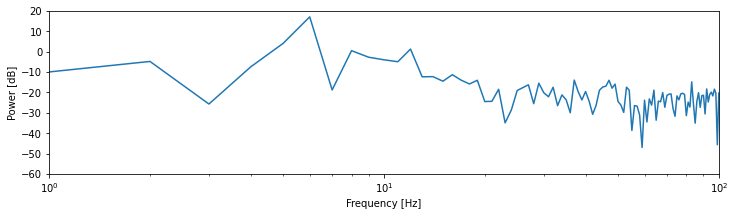

In [10]:
semilogx(faxis, 10 * log10(Sxx)) # Plot spectrum vs frequency,
xlim([1, 100])                      # ... in select frequency range,
ylim([-60, 20])                     # ... and power range,
xlabel('Frequency [Hz]')                # ... with axes labeled.
ylabel('Power [dB]')
show()

# To emphasize smaller peak